# Modelling via scikit-learn

This notebook performs model fitting and evaluating on hold out areas, using models from scikit-learn.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## File Locations

In [2]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

## Load Data

In [3]:
# !gsutil cp gs://immap-wash-training/training/20200916_*.csv {data_dir}
df = pd.read_csv(data_dir + '20200916_dataset.csv')
df.shape

(57036, 45)

## Fit, Predict and Evaluate Models Using 5-fold Cross Validation
Trains a random forest model to predict each of the 3 WASH indicators, setting random 20% of the data (whichever the area) as test data and everything else as training data. The train-test split is done for 5 different folds. The data that was split into different folds includes **both Urban and Rural** data.


Access to water

Average Metrics
correlation: 0.7723
r2: 0.5967
rmse: 0.1291


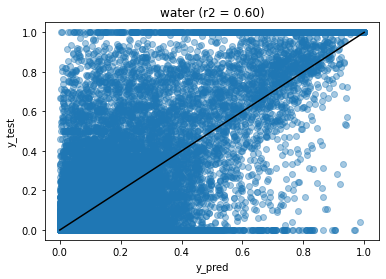


Access to toilet

Average Metrics
correlation: 0.7318
r2: 0.5357
rmse: 0.1233


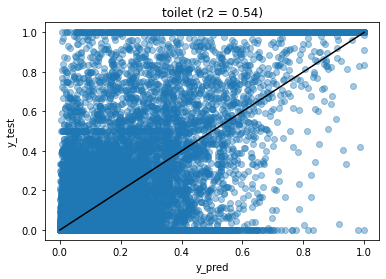


Access to sewage

Average Metrics
correlation: 0.8046
r2: 0.6474
rmse: 0.1707


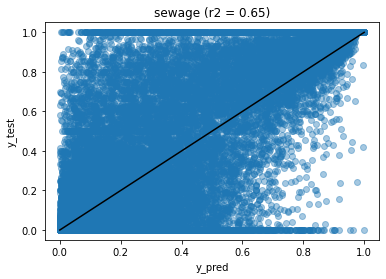

In [9]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state=42)

res = modelutils.fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all_250mv2')
res = pd.read_csv(data_dir + 'all_250mv2_randomsplit_results.csv')
modelutils.summarize_metrics(res, iterate_over = 'split_id', prefix = 'all_250mv2')